In [2]:
from forecast_emulator import ForecastEmulator
from datetime import datetime, timedelta
import plotly.express as px
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

# Storage in Day-Ahead Market
- Create a generic ESS class for a simple storage model without efficiency
- Create an optimization model that simulates the participation of a storage in day-market with profit maximisation
thanks to price arbitrage

In [1]:
from dataclasses import dataclass
@dataclass
class ESS:
    pc_max: float = 0.0   # Rated Charge Power
    pd_max: float = 0.0   # Rated Discharge Power
    e_max: float = 0.0    # Rated Energy
    effc: float = 0.9     # Charge efficiency
    effd: float = 0.9     # Discharge efficiency
    soc_min : float = 0.0 #Minimum state of charge
    soc_max : float = 100.0 #Maximum state of charge
    soc_init: float = 50.0  # Initial State of Charge


In [4]:
import pyomo.environ as pyo

def da_opt(price , ESS):

    deltaT=1  #1h time step in DA market
    T = len(price)

    model = pyo.ConcreteModel()

    # Variables
    model.pc = pyo.Var(range(T), within=pyo.NonNegativeReals, bounds = [0 ,ESS.pc_max ])  # charging
    model.pd = pyo.Var(range(T), within=pyo.NonNegativeReals, bounds = [0 ,ESS.pd_max ])  # discharging
    model.soc = pyo.Var(range(T+1), within=pyo.NonNegativeReals, bounds = [ESS.soc_min ,ESS.soc_max ] ) # state of

    # Objective: maximize profit
    model.obj = pyo.Objective(
        expr=sum(model.pd[t]*price[t] - model.pc[t]*price[t] for t in range(T)),
        sense=pyo.maximize
    )

    # Constraints list
    model.constraints = pyo.ConstraintList()

    # Initial SOC
    model.constraints.add(model.soc[0] ==ESS.soc_init)
    model.constraints.add(model.soc[T] ==ESS.soc_init)

    for t in range(T):
            model.constraints.add(
                model.soc[t+1] == model.soc[t]
                + (ESS.effc*model.pc[t] - (1/ESS.effd)*model.pd[t])*deltaT/max(1e-6,ESS.e_max)*100
            )

    solver = pyo.SolverFactory("gurobi")
    solver.solve(model)

    return np.asarray([pyo.value(model.pd[t]) - pyo.value(model.pc[t]) for t in range(T)])


# Setup Simulation
- Create an ESS object
- Set the simulation horizon
- Compute the optimal profit - ie perfect forecast

In [10]:
ess=ESS(pc_max = 1, pd_max = 1, effc = 1, effd = 1, e_max =2 )
data = pd.read_excel('../data/da_prices_fr.xlsx',index_col = 0)
data=data['price(€/MWh)']
data.index = pd.to_datetime(data.index).round("s")
start_time = datetime(2021,10,1,0,0)
end_time = datetime(2021,11,1,0,0)

In [6]:
profit_opt=0
start_time_t=start_time

while start_time_t < end_time :

    # Optimal daily profit
    price = data.loc[start_time_t: start_time_t + timedelta(hours=24)].iloc[:-1].values
    pess = da_opt(price,ess)
    profit_opt = profit_opt + sum(pess*price)

    # Increment start time
    start_time_t = start_time_t + timedelta(days=1)

print(f"optimal profit k€  {profit_opt/1000:.2f}")

optimal profit k€  12.14


# Run Test Simulations
- Generate a forecast emulator based on prices profiles
- Loop over different error values with several runs
- Store and display the results

In [7]:
emulator = ForecastEmulator(ts_in = data,
                            nb_states = 50,
                            nb_forecast_profiles =300)

In [8]:
from tqdm import tqdm

error_list= np.linspace(5,50,10)
nb_runs = 10
total = len(error_list)*nb_runs
results = []

start_time_t = start_time

with tqdm(total = total) as pbar:
    for e in error_list:
        for run in range(nb_runs):

            profit = 0
            start_time_t=start_time

            while start_time_t < end_time :

                # Optimal daily profit
                reference, price = emulator.forecast(start_time = start_time_t,
                                                     duration_minutes  = 60*24,
                                                     target_error = e,
                                                     metric = 'nrmse',
                                                     selection = 'closest')
                pess = da_opt(price.values,ess)
                price_real = data.loc[start_time_t: start_time_t + timedelta(hours=24)].iloc[:-1].values
                profit = profit  + sum(pess*price_real)

                # Increment start time
                start_time_t = start_time_t + timedelta(days=1)

            # Replace this with your actual simulation function
            results.append({'error': e, 'run': run+1, 'precision': profit/profit_opt*100})
            pbar.update(1)

# Convert to DataFrame
df = pd.DataFrame(results)

100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


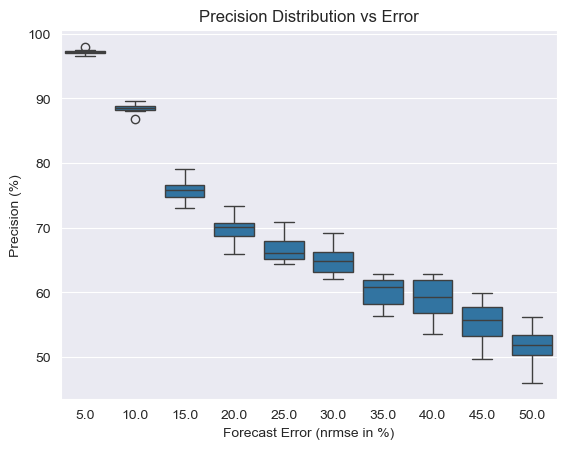

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(data=df, x="error", y="precision")
plt.xlabel("Forecast Error (nrmse in %)")
plt.ylabel("Precision (%)")
plt.title("Precision Distribution vs Error")
plt.show()
